In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.io import FortranFile
from cobaya.model import get_model
import yaml
import os
from getdist import plots, MCSamples
from cobaya.conventions import Const, packages_path_input
from scipy.optimize import minimize
from scipy.optimize import differential_evolution

In [2]:
path_GLM_data = '../GLM_data/'

In [3]:

getdist_settings = {
    'smooth_scale_1D': 0.3,
    'smooth_scale_2D': 0.4,
    'boundary_correction_order': 1,
    'mult_bias_correction_order': 1,
    }


# BAO

In [4]:
yaml_path = "../chains/LCDM/01p1_LCDM_BAO_DESIDR2.input.yaml"

# define the path to the YAML parameters file:
yaml_params = yaml_path #os.path.join(chains_dir, name + '.input.yaml')
# load the parameters from the YAML file:
with open(yaml_params, 'r') as f:
    params_dict = yaml.safe_load(f)
# remove the 'path' key from the 'camb' dictionary if it exists:
if 'path' in params_dict.get('theory', {}).get('camb', {}):
    del params_dict['theory']['camb']['path']
if 'recombination_model' in params_dict.get('theory', {}).get('camb', {}).get('extra_args', {}):
    del params_dict['theory']['camb']['extra_args']['recombination_model']
if 'max_zrei'in params_dict.get('theory', {}).get('camb', {}).get('extra_args', {}):
    del params_dict['theory']['camb']['extra_args']['max_zrei']
    print('Removed "max_zrei" from the "camb" extra_args in the YAML parameters file.')
# build the model:
model = get_model(params_dict)

Removed "max_zrei" from the "camb" extra_args in the YAML parameters file.
[model] *WARNING* Ignored blocks/options: ['sampler', 'output']
[camb] `camb` module loaded successfully from /opt/anaconda3/envs/snpy/lib/python3.10/site-packages/camb
[bao.desi_dr2.desi_bao_all] Initialized.


In [5]:
chains_dir = os.path.join('../chains/LCDM/')

# import chain
from cobaya import load_samples

name = '01p1_LCDM_BAO_DESIDR2'
chain = load_samples(os.path.join(chains_dir, name), skip=0.3, to_getdist=True)
chain.label = name
chain.root = os.path.join(chains_dir, name)
chain.updateSettings(getdist_settings)
chain.updateBaseStatistics()
chain.getConvergeTests()
print(chain.label+': R =', round(chain.GelmanRubin, 4))


BestFit = chain.getBestFit()
BestFitDict = BestFit.getParamDict()

params = model.parameterization.sampled_params()
for p in params.keys():
    params[p] = BestFitDict[p]  # Set the best fit values for all parameters

params_values = np.array([params[p] for p in params.keys()])
params_names = np.array(list(params.keys()))

[samplecollection] Loaded 4340 sample points from '../chains/LCDM/01p1_LCDM_BAO_DESIDR2.1.txt'
[samplecollection] Loaded 3987 sample points from '../chains/LCDM/01p1_LCDM_BAO_DESIDR2.2.txt'
[samplecollection] Loaded 4246 sample points from '../chains/LCDM/01p1_LCDM_BAO_DESIDR2.3.txt'
[samplecollection] Loaded 4264 sample points from '../chains/LCDM/01p1_LCDM_BAO_DESIDR2.4.txt'
01p1_LCDM_BAO_DESIDR2: R = 0.0081


### Obtaining Covariance matrix 

In [6]:
# Load the covariance matrix from the data
cov_data =  np.load(path_GLM_data + "cov_data_BAO.npy")
# Load the posterior covariance matrix from the file in the chains
cov_posterior = np.loadtxt('../chains/LCDM/01p1_LCDM_BAO_DESIDR2.covmat')


# import chain for the prior and then extract the covariance matrix
chains_dir = os.path.join('../chains/LCDM/')
from cobaya import load_samples
name = '01p1_LCDM_BAO_DESIDR2.prior'
chain_prior = load_samples(os.path.join(chains_dir, name), skip=0.3, to_getdist=True)
chain_prior.label = name
chain_prior.root = os.path.join(chains_dir, name)
chain_prior.updateSettings(getdist_settings)
chain_prior.updateBaseStatistics()
chain_prior.getConvergeTests()
print(chain_prior.label+': R =', round(chain_prior.GelmanRubin, 4))
# Extract the parameter names.
param_names = list(params.keys())

cov_prior = chain.cov(pars=param_names)


[samplecollection] Loaded 350 sample points from '../chains/LCDM/01p1_LCDM_BAO_DESIDR2.prior.1.txt'
[samplecollection] Loaded 350 sample points from '../chains/LCDM/01p1_LCDM_BAO_DESIDR2.prior.2.txt'
[samplecollection] Loaded 350 sample points from '../chains/LCDM/01p1_LCDM_BAO_DESIDR2.prior.3.txt'
[samplecollection] Loaded 350 sample points from '../chains/LCDM/01p1_LCDM_BAO_DESIDR2.prior.4.txt'
01p1_LCDM_BAO_DESIDR2.prior: R = 0.0058


## jacobian computation

In [7]:
# This is necessary to initialize the model and its components
model.loglike(params, return_derived=False) 
# Get the model prediction for the data
temp = model.components[0]
model_pred = np.array([temp.theory_fun(z,obs) for z,obs in zip(temp.data['z'], temp.data['observable'])]).T[0]
#site-packages/cobaya/likelihoods/base_classes/BAO.py:line 345

In [8]:

x_obs = temp.data['value'].values

In [9]:
# Compute the Jacobian numerically using finite differences on the model predictions.
scale=0.01
jacobian = np.zeros((len(temp.data['value']), len(params)))
for i, p in enumerate(params.keys()):
    param_perturbed_plus = params.copy()  # Create a copy of the parameters
    param_perturbed_minus = params.copy()  # Create a copy of the parameters

    param_perturbed_plus[p] *= 1 + scale  # Perturb the parameter
    param_perturbed_minus[p] *= 1 - scale  # Perturb the parameter

    model.loglike(param_perturbed_minus, return_derived=False)
    temp = model.components[0]
    model_pred_minus = np.array([temp.theory_fun(z,obs) for z,obs in zip(temp.data['z'], temp.data['observable'])]).T[0]


    model.loglike(param_perturbed_plus, return_derived=False)
    temp = model.components[0]
    model_pred_plus = np.array([temp.theory_fun(z,obs) for z,obs in zip(temp.data['z'], temp.data['observable'])]).T[0]


    jacobian[:, i] = (model_pred_plus - model_pred_minus) / (param_perturbed_plus[p] - param_perturbed_minus[p]) / 2  # Numerical derivative  

In [10]:
# We need to ensure that the Jacobian is not singular, so we add a small numerical errors to the diagonal if necessary.
jacobian_fixed = np.copy(jacobian)
for i in range(len(params.keys())):
    if np.all(jacobian_fixed[:,i]== np.zeros((13))):
        jacobian_fixed[i,i]=10**(-2)


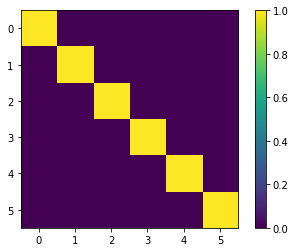

In [11]:
# Computing M_tilde and then making sure that M_tilde @ jacobian_fixed is the identity.

M_tilde = np.linalg.inv(np.transpose(jacobian_fixed) @ np.linalg.inv(cov_data) @ jacobian_fixed) @ jacobian_fixed.T @ np.linalg.inv(cov_data) 

plt.imshow(M_tilde @ jacobian_fixed)
plt.colorbar()

In [12]:
# Now we can compute the maximum likelihood estimate of the parameters using the formula.
theta_ML = np.array(list(params_values)) + cov_posterior @ np.linalg.inv(cov_prior) @ M_tilde @(x_obs-model_pred)

## Compting the estimators

In [ ]:
# Here we compute the maximum likelihood estimator Q_ML (the log-likelihood is already normalized so we don't need extra terms in Q_ML) ref : 120
Q_ML = -2*model.loglike(dict(zip(param_names, theta_ML)), return_derived=False)

#probability to exceed the observed value
from scipy.stats import chi2
p_value = chi2.sf(Q_ML,13-6)
p_value

0.0

In [34]:
_temp = np.dot(np.linalg.inv(cov_prior), cov_posterior)
# compute Neff from the regularized spectrum of the eigenvalues:
_eigv, _eigvec = np.linalg.eig(_temp)
_eigv[_eigv > 1.] = 1.
_eigv[_eigv < 0.] = 0.
#
_Ntot = len(_eigv)
_Neff = _Ntot - np.real(np.sum(_eigv))
_Neff


0.03760089739108263

In [38]:
# Now we can compute the estimor Q_MAP, which is the log-likelihood at the best fit parameters.ref: 125
Q_MAP = -2*model.loglike(params, return_derived=False)   

from scipy.stats import chi2

#probability to exceed the observed value
p_value = chi2.sf(Q_MAP,13-_Neff)
p_value

0.6670009711121831

In [39]:
# Finally, we can compute the prior term Q_prior using ref 134.
Q_prior = -2*(model.loglike(params, return_derived=False)  + model.logpost(params))-6*np.log(2*np.pi)-np.log(np.linalg.det(cov_prior)) 

from scipy.stats import chi2
#probability to exceed the observed value
p_value = chi2.sf(Q_prior,13)
p_value

0.00012349300627969052

In [18]:
# Here we compute the bayesian dimensionality
C = np.linalg.inv(np.linalg.inv(cov_posterior)-np.linalg.inv(cov_prior))
CM1 =  np.linalg.inv(cov_posterior)-np.linalg.inv(cov_prior)

d_Bayes = np.trace(CM1 @ cov_posterior @ CM1 @ cov_posterior) + 2*(np.array(list(params.values()))-theta_ML).T @ CM1 @ cov_posterior @ CM1 @ (np.array(list(params.values()))-theta_ML)   